In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from shark.utils import nb_init

nb_init()

INFO | nb_init | Set current dir to chess
INFO | nb_init | You are using Python 3.10.10 (main, Sep 14 2023, 16:59:47) [Clang 14.0.3 (clang-1403.0.22.14.1)]


# PPO againt on Inverted Double Pendulum

In [9]:
from loguru import logger
import os
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
import pandas as pd

from shark.models import PPOPendulum
from shark.utils import plot_metrics

## Create model

We choose the gymnasium environment here.

In [10]:
frame_skip = 1
frames_per_batch = frame_skip * 100
model = PPOPendulum(
    frame_skip=frame_skip,
    frames_per_batch=frames_per_batch,
)

## Rollout

We can immediately try to play, and check what playing returns.

In [11]:
rollout = model.env.rollout(3)
logger.info(f"Rollout of three steps: {rollout}")
logger.info(f"Shape of the rollout TensorDict: {rollout.batch_size}")
logger.info(f"Running policy: {model.policy_module(model.env.reset())}")
logger.info(f"Running value: {model.value_module(model.env.reset())}")

INFO | <module> | Rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([1, 3, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([1, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            ba

## Data

This is what a batch of data looks like.

In [12]:
# Collector
collector = model.train_dataloader()
for _, tensordict_data in enumerate(collector):
    logger.info(f"Tensordict data:\n{tensordict_data}")
    break

INFO | <module> | Tensordict data:
TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([1, 100]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([1, 100]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([1, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1, 100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([1, 100, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([1, 100, 1]), device=cpu, dtype=torch.float32, is

In [13]:
# Training
trainer = pl.Trainer(
    accelerator="cpu",
    max_steps=8,
    val_check_interval=1,
    log_every_n_steps=1,
    logger=CSVLogger(
        save_dir="pytest_artifacts",
        name=model.__class__.__name__,
    ),
)
trainer.fit(model)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.

  | Name             | Type               | Params
--------------------------------------------------------
0 | env              | SerialEnv          | 0     
1 | loss_module      | ClipPPOLoss        | 270 K 
2 | policy_module    | ProbabilisticActor | 135 K 
3 | value_module     | ValueOperator      | 134 K 
4 | advantage_module | GAE                | 0     
--------------------------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.080     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=8` reached.


In [14]:
# Get logged stuff
log_dir = trainer.log_dir
assert isinstance(log_dir, str)
logs = trainer.logged_metrics
assert isinstance(logs, dict)
logger.info(log_dir)
logger.info(logs)
filename = os.path.join(log_dir, "metrics.csv")
df = pd.read_csv(filename)
logger.info(df.head())

INFO | <module> | pytest_artifacts/PPOPendulum/version_32
INFO | <module> | {'loss_objective/train': tensor(-8.8461), 'loss_entropy/train': tensor(-3.6197e-05), 'loss_critic/train': tensor(8.3461), 'loss/train': tensor(-49.9971), 'reward/train': tensor(8.9947), 'step_count/train': tensor(4.), 'reward/eval': tensor(9.0100), 'reward_sum/eval': tensor(36.0401), 'step_count/eval': tensor(3.)}
INFO | <module> |    epoch  loss/train  loss_critic/train  loss_entropy/train  \
0      0  -49.998695           8.046918            0.000007   
1      0  -49.997986           8.406179            0.000095   
2      0  -49.999058           8.472415            0.000018   
3      0  -49.997715           8.139165            0.000018   
4      0  -49.997772           8.415380            0.000112   

   loss_objective/train  reward/eval  reward/train  reward_sum/eval  step  \
0             -8.546918     9.019761      8.993592        36.079044     0   
1             -8.906179     9.048302      8.974467       

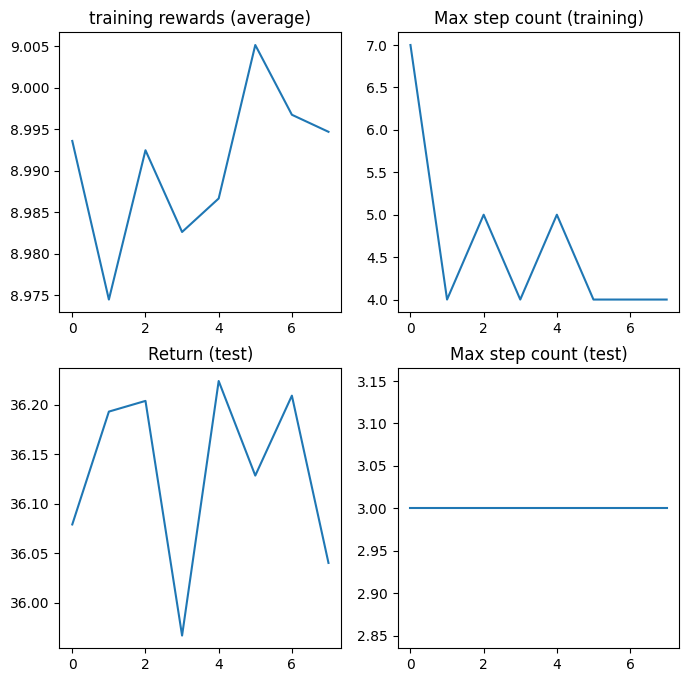

In [15]:
import matplotlib.pyplot as plt

# Plot
plot_metrics(df, show=True)